In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot

# 讀取CSV資料
file_path = '../mangodata/MangoIrwin.csv'
data = pd.read_csv(file_path)

# 將資料轉換為DataFrame
df = pd.DataFrame(data)
df

,日期,市場,產品,上價,中價,下價,平均價(元/公斤),交易量(公斤)
0,2014/4/1,台北二,芒果 愛文,108.3,73.5,43.7,74.5,36
1,2014/4/3,台北二,芒果 愛文,120.0,116.7,105.0,115.0,18
2,2014/4/4,台北二,芒果 愛文,123.9,95.7,55.6,93.3,45
3,2014/4/8,台北二,芒果 愛文,90.0,69.8,51.3,70.2,34
4,2014/4/9,台北二,芒果 愛文,60.0,46.8,32.5,46.6,50
...,...,...,...,...,...,...,...,...
2993,2023/9/26,台北一,芒果 愛文,168.0,85.6,44.1,93.8,"1,668"
2994,2023/9/27,台北一,芒果 愛文,207.6,88.4,36.4,101.9,"1,497"
2995,2023/9/28,台北一,芒果 愛文,183.6,87.6,41.4,97.5,"1,632"
2996,2023/9/29,台北一,芒果 愛文,195.2,74.1,26.4,88.8,"1,439"


In [2]:
# 篩選出 "台北二" 市場的所有資料並使用 .loc 進行操作
df_taipei2= df.loc[df['市場'] == '台北二'].copy()
# 將'日期'轉換為datetime格式
df_taipei2['日期'] = pd.to_datetime(df_taipei2['日期'])
# 從'日期'中提取年, 月, 日
df_taipei2['年份']= df_taipei2['日期'].dt.year
df_taipei2['月份']= df_taipei2['日期'].dt.month
df_taipei2['日']= df_taipei2['日期'].dt.day

# 移除交易量中的逗號，並轉換為數值型態
df_taipei2['交易量(公斤)'] = df_taipei2['交易量(公斤)'].str.replace(',', '').astype(float)

# 檢查日期欄位是否有重複值，並移除重複日期
df_taipei1 = df_taipei2.drop_duplicates(subset=['日期'])

# 按年份分組並收集日期資料到字典中
year_datas = {}
for year, group in df_taipei2.groupby('年份'):
    year_datas[year] = {
         # 將datetime轉換為字串列表
        '日期': group['日期'].dt.strftime('%Y/%m/%d').tolist(),
        '市場': group['市場'].tolist(),
        '產品': group['產品'].tolist(),
        '上價': group['上價'].tolist(),
        '中價': group['中價'].tolist(),
        '下價': group['下價'].tolist(),
        '平均價(元/公斤)': group['平均價(元/公斤)'].tolist(),
        '交易量(公斤)': group['交易量(公斤)'].tolist()
         
    }

In [3]:
# 創建空的DataFrame來存儲結果
df = pd.DataFrame()

# 迴圈處理每個年份的資料
for year, year_data in year_datas.items():
    # 將資料轉換為DataFrame並將日期轉換為datetime格式
    df_year_data = pd.DataFrame(year_data)
    df_year_data['日期'] = pd.to_datetime(df_year_data['日期'])
    
    # 日期範圍（4月到9月）
    start_date = f'{year}-04-01'
    end_date = f'{year}-09-30'
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # 將日期設置為索引
    df_year_data.set_index('日期', inplace=True)

     # 重新索引以包含所有日期
    df_year_data = df_year_data.reindex(date_range)
    
    # 或者使用平均值插補
    df_year_data['平均價(元/公斤)'] = df_year_data['平均價(元/公斤)'].interpolate(method='linear')
    df_year_data['上價'] = df_year_data['上價'].interpolate(method='linear')
    df_year_data['中價'] = df_year_data['中價'].interpolate(method='linear')
    df_year_data['下價'] = df_year_data['下價'].interpolate(method='linear')
    df_year_data['交易量(公斤)'] = df_year_data['交易量(公斤)'].interpolate(method='linear')

    # 使用前向填充和後向填充來處理剩餘的缺失值
    df_year_data['平均價(元/公斤)'] = df_year_data['平均價(元/公斤)'].ffill().bfill()
    df_year_data['上價'] = df_year_data['上價'].ffill().bfill()
    df_year_data['中價'] = df_year_data['中價'].ffill().bfill()
    df_year_data['下價'] = df_year_data['下價'].ffill().bfill()
    df_year_data['交易量(公斤)'] = df_year_data['交易量(公斤)'].ffill().bfill()

    # 將交易量(公斤)轉換為整數
    df_year_data['交易量(公斤)'] = df_year_data['交易量(公斤)'].astype(int)


    # 填充市場和產品欄位
    market_value = year_data['市場'][0] if '市場' in year_data else '未知市場'
    product_value = year_data['產品'][0] if '產品' in year_data else '未知產品'
    df_year_data['市場'] = market_value
    df_year_data['產品'] = product_value

    # 重置索引並添加年份列
    df_year_data.reset_index(inplace=True)
    
    # 將索引顯示到日期欄位
    df_year_data.rename(columns={'index': '日期'}, inplace=True)
    
    # 將處理好的數據添加到結果DataFrame中
    df = pd.concat([df, df_year_data], ignore_index=True)




,日期,市場,產品,上價,中價,下價,平均價(元/公斤),交易量(公斤)
0,2014-04-01,台北二,芒果 愛文,108.300,73.500,43.700,74.500,36
1,2014-04-02,台北二,芒果 愛文,114.150,95.100,74.350,94.750,27
2,2014-04-03,台北二,芒果 愛文,120.000,116.700,105.000,115.000,18
3,2014-04-04,台北二,芒果 愛文,123.900,95.700,55.600,93.300,45
4,2014-04-05,台北二,芒果 愛文,115.425,89.225,54.525,87.525,42
...,...,...,...,...,...,...,...,...
1825,2023-09-26,台北二,芒果 愛文,137.200,72.500,25.400,76.000,2358
1826,2023-09-27,台北二,芒果 愛文,130.000,55.900,25.800,64.700,1536
1827,2023-09-28,台北二,芒果 愛文,136.600,67.700,27.400,73.400,1848
1828,2023-09-29,台北二,芒果 愛文,168.300,73.800,27.100,83.300,1464


In [4]:
# 準備進行SARIMA建模的資料
col= ['上價','中價','下價','平均價(元/公斤)']
data = df[col]
data

,上價,中價,下價,平均價(元/公斤)
0,108.300,73.500,43.700,74.500
1,114.150,95.100,74.350,94.750
2,120.000,116.700,105.000,115.000
3,123.900,95.700,55.600,93.300
4,115.425,89.225,54.525,87.525
...,...,...,...,...
1825,137.200,72.500,25.400,76.000
1826,130.000,55.900,25.800,64.700
1827,136.600,67.700,27.400,73.400
1828,168.300,73.800,27.100,83.300


In [ ]:
colx = ['上價','中價','下價']
x = df[colx]

coly = ['平均價(元/公斤)']
y = df[coly]
print(x)
print(y)

In [5]:
# 分割資料為訓練集和測試集
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

In [6]:
# 使用 "平均價(元/公斤)" 作為目標變量
train_target = train['平均價(元/公斤)']
test_target = test['平均價(元/公斤)']

# 建立和訓練 SARIMA 模型
# 注意這裡設置了季節性順序為(1, 1, 1, 6)因為季節性是每年6個月（4到9月）
model = SARIMAX(train_target, order=(1, 1, 1), seasonal_order=(1, 1, 1, 180))
model_fit = model.fit(method='lbfgs', maxiter=200, disp=False)

# 顯示模型摘要
print(model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:                           平均價(元/公斤)   No. Observations:                 1464
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 180)   Log Likelihood               -5643.001
Date:                             Wed, 31 Jul 2024   AIC                          11296.001
Time:                                     13:10:05   BIC                          11321.786
Sample:                                          0   HQIC                         11305.682
                                            - 1464                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1109      0.022      5.123      0.000       0.068       0.153
ma.L1         -0.5487      

In [7]:
# 預測
y_pred_train = model_fit.predict(start=train.index[0], end=train.index[-1], dynamic=False)
y_pred_test = model_fit.predict(start=test.index[0], end=test.index[-1], dynamic=False)

In [8]:
# 預測訓練集和測試集的值
y_pred_train = model_fit.predict(start=0, end=len(train_target)-1)
y_pred_test = model_fit.predict(start=len(train_target), end=len(train_target) + len(test_target) - 1)

# 計算評估指標
mse_train = mean_squared_error(train_target, y_pred_train)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(train_target, y_pred_train)

mse_test = mean_squared_error(test_target, y_pred_test)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(test_target, y_pred_test)

# 顯示評估指標
print("訓練集 MSE:", mse_train)
print("訓練集 RMSE:", rmse_train)
print("訓練集 MAE:", mae_train)
print("測試集 MSE:", mse_test)
print("測試集 RMSE:", rmse_test)
print("測試集 MAE:", mae_test)

訓練集 MSE: 381.91211649625694
訓練集 RMSE: 19.542571900756997
訓練集 MAE: 10.692095418335866
測試集 MSE: 1325.078291900569
測試集 RMSE: 36.40162485247834
測試集 MAE: 30.28855049325239


/opt/miniconda3/envs/venv2/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24179 (\N{CJK UNIFIED IDEOGRAPH-5E73}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/envs/venv2/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 22343 (\N{CJK UNIFIED IDEOGRAPH-5747}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/envs/venv2/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20729 (\N{CJK UNIFIED IDEOGRAPH-50F9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/envs/venv2/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/miniconda3/envs/venv2/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 20844

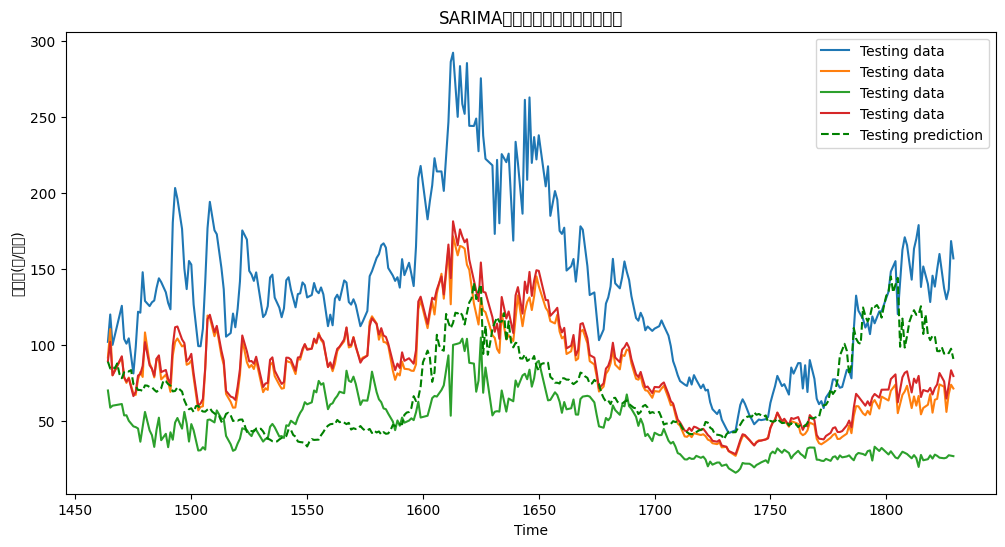

In [9]:
# 視覺化
plt.figure(figsize=(12, 6))
# plt.plot(train.index, train, label='Training data')
plt.plot(test.index, test, label='Testing data')
# plt.plot(train.index, y_pred_train, color='red', linestyle='--', label='Training prediction')
plt.plot(test.index, y_pred_test, color='green', linestyle='--', label='Testing prediction')
plt.xlabel('Time')
plt.ylabel('平均價(元/公斤)')
plt.title('SARIMA模型的時間序列分析和預測')
plt.legend()
plt.show()